### Instalação

In [23]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [26]:
#pip install --upgrade pandas

##### Referencia

https://github.com/Giffy/MongoDB_PyMongo_Tutorial/blob/master/1_1_First_steps_with_MongoDB_PyMongo.ipynb

### Carraegar Dados

In [27]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import json
#from pandas.io.json import json_normalize

In [28]:
from dotenv import load_dotenv
import os

# Carregue as variáveis do arquivo .env
load_dotenv()

os.getenv("MINHAS_CREDENCIAIS_V1")
# Acesse as variáveis de ambiente
valor_das_credenciais = os.getenv("MINHAS_CREDENCIAIS_V1")
MINIO_ROOT_URL= os.getenv("MINIO_ROOT_URL")
print(f"Valor das credenciais: {valor_das_credenciais}")


Valor das credenciais: no arquivo .env


In [ ]:
client = MongoClient({MINIO_ROOT_URL})
db = client.my_database

server_info = client.server_info()
print (server_info)

In [30]:

database_names = client.list_database_names()
#print ("\ndatabases:", database_names)


# Show existing database names
client.list_database_names()

# Set database name to work with. If it doesn't exist, it will be created as soon as one document is added.
db = client.cargarecuperadb

# Show Collections. Query returns a Cursor [ ] ,  list it to see the content
list (db.list_collections())
# empty list '[]' means that there are not collections in database

# Set the collection to work with
collection = db.dadosRecuperaDTO

In [ ]:

list( collection.find().limit(1) )                      # To know how many documents are stored in the database

In [32]:
fields = { '_id' : 0,
          'dataConsumer' : 1
            , 'requestChassiRessarcimento.chassiRessarcimento.operacao': 2    
            , 'ressarcimentoNLP.ressarcivel': 1
            , 'requestChassiRessarcimento.chassiRessarcimento.atributosSinistro.ano': 1
            , 'requestChassiRessarcimento.chassiRessarcimento.atributosMotorDeRegra.descricaoAvisoSinistro': 1
            , 'requestChassiRessarcimento.chassiRessarcimento.atributosMotorDeRegra.naturezaSinistro': 1
         }

##### Filtro Por Periodo

In [77]:
from datetime import datetime

filters = {
     'requestChassiRessarcimento.chassiRessarcimento.operacao': {'$in': ['CADASTRAR']}, 
     'requestChassiRessarcimento.chassiRessarcimento.atributosSinistro.ano': {'$in': ['2023']}, 
     'ressarcimentoNLP.ressarcivel': {'$in': ['SIM', 'NAO']}
    
}
query = list(collection.find( filters , fields ).sort('_id', -1).limit(10000))
count = len(query)
count

8843

### Análise Exploratória e Limpeza

In [ ]:
#datapoints = list (  collection.find().limit(1) )
df = pd.json_normalize(query)
df.head()

In [79]:
mapa = {
    'requestChassiRessarcimento.chassiRessarcimento.atributosSinistro.ano': 'ANO'
    ,'requestChassiRessarcimento.chassiRessarcimento.atributosMotorDeRegra.descricaoAvisoSinistro': 'DESCRICAO'
    , 'requestChassiRessarcimento.chassiRessarcimento.atributosMotorDeRegra.naturezaSinistro': 'GRAU'
    , 'ressarcimentoNLP.ressarcivel': 'SITUACAO'
}

mapaList = list ( mapa)
df_mapa = pd.DataFrame(mapaList)
df_mapa

,0
0,requestChassiRessarcimento.chassiRessarcimento...
1,requestChassiRessarcimento.chassiRessarcimento...
2,requestChassiRessarcimento.chassiRessarcimento...
3,ressarcimentoNLP.ressarcivel


In [ ]:
df_subset = df[mapaList].rename(columns=mapa)
df_subset

In [81]:
df_subset = df_subset.drop_duplicates()
df_subset.count()

ANO          758
DESCRICAO    758
GRAU         758
SITUACAO     758
dtype: int64

In [ ]:
df_subset['SINISTRO'] = range(1, len(df_subset) + 1)
df_subset

In [ ]:
df_subset

In [ ]:

filtered_df = df_subset[(df_subset['SITUACAO'] == 'NAO')]
filtered_df

In [ ]:
#Remove the NaN values using dropna() method
df_subset.dropna(axis=1)

##### Bibliotecas

In [86]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import pickle
import warnings
warnings.filterwarnings("ignore")

### Análise Exploratória e Limpeza

> Bloco com recuo



In [87]:
df_sinisitro=df_subset
df_sinisitro.columns

Index(['ANO', 'DESCRICAO', 'GRAU', 'SITUACAO', 'SINISTRO'], dtype='object')

In [88]:
#Image(filename='Tipos_de_Variaveis.png', width=1000, height=1000)

In [89]:
def show_null(df):
    null_columns = (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False).index

    null_data = pd.concat([df.isnull().sum(axis=0),
                           (df.isnull().sum(axis=0)/len(df)).sort_values(ascending=False),
                           df.loc[:, df.columns.isin(list(null_columns))].dtypes],
                          axis=1)

    null_data = null_data.rename(columns={0: '#',
                                          1: '% null',
                                          2: 'type'}).sort_values(ascending=False,
                                                                  by='% null')

    return null_data

In [90]:
def plot_num(df, feature):
    fig = plt.figure(figsize=(12,8))
    gs = GridSpec(1,2)
    sns.countplot(x=feature, data=df, color='firebrick', ax=fig.add_subplot(gs[0,0]))
    plt.xlabel(feature)
    sns.stripplot(x=df[feature], color='darkcyan', ax=fig.add_subplot(gs[0,1]))
    plt.xlabel(None)
    plt.show()

    #sns.countplot(x='seguradoAssumeCulpa', data=df_subset2);

In [91]:
def plot_cat(df, feature):
    fig = plt.figure(figsize=(12,8))
    ax = sns.countplot(data=df, x=feature)
    for p in ax.patches:

        ax.annotate(f'\n{p.get_height()}',
                    (p.get_x()+0.4, p.get_height()+5),
                    ha='center',
                    color='black')

    plt.xlabel('\n' + feature)
    plt.ylabel('Quantidade de Clientes')
    plt.show()

In [ ]:
df_subset.head()

In [93]:
show_null(df_sinisitro)

,#,% null,type
ANO,0,0.0,object
DESCRICAO,0,0.0,object
GRAU,0,0.0,object
SITUACAO,0,0.0,object
SINISTRO,0,0.0,int64


In [ ]:
df_sinisitro.dropna(inplace=True)
df_sinisitro

df_subset2 = df_sinisitro[(df_sinisitro['SITUACAO'] == 'NAO') | (df_sinisitro['SITUACAO'] == 'SIM')]
df_subset2

##### número de ocorrências de cada valor na coluna “SITUACAO”

In [95]:
counts = df_sinisitro['SITUACAO'].value_counts()
counts

SITUACAO
SIM    487
NAO    271
Name: count, dtype: int64

##### número de ocorrências de cada valor na coluna “GRAU”

In [103]:
counts = df_sinisitro['GRAU'].value_counts()
counts

GRAU
_10_COLISAO                      479
_30_ROUBO                         75
_50_ENCHENTE_INUNDACAO            54
_20_INCENDIO                      44
_36_FURTO_TOTAL                   30
_90_ACIDENTES_PESSOAIS            28
_64_ROUBO_LOCALIZADO              16
_71_VIDROS                        13
_76_VIDROS_RETR_LANTER_FAROIS     11
_68_FURTO_LOCALIZADO               7
_65_ROUBO_DE_ACESSORIOS            1
Name: count, dtype: int64

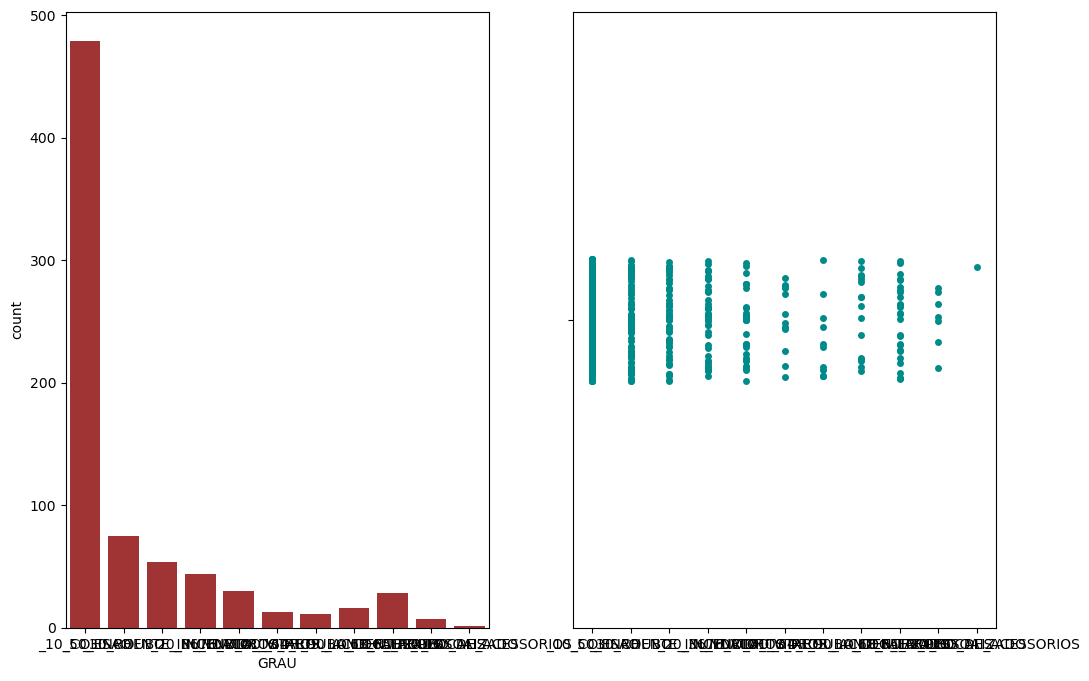

In [96]:
plot_num(df_sinisitro, 'GRAU')

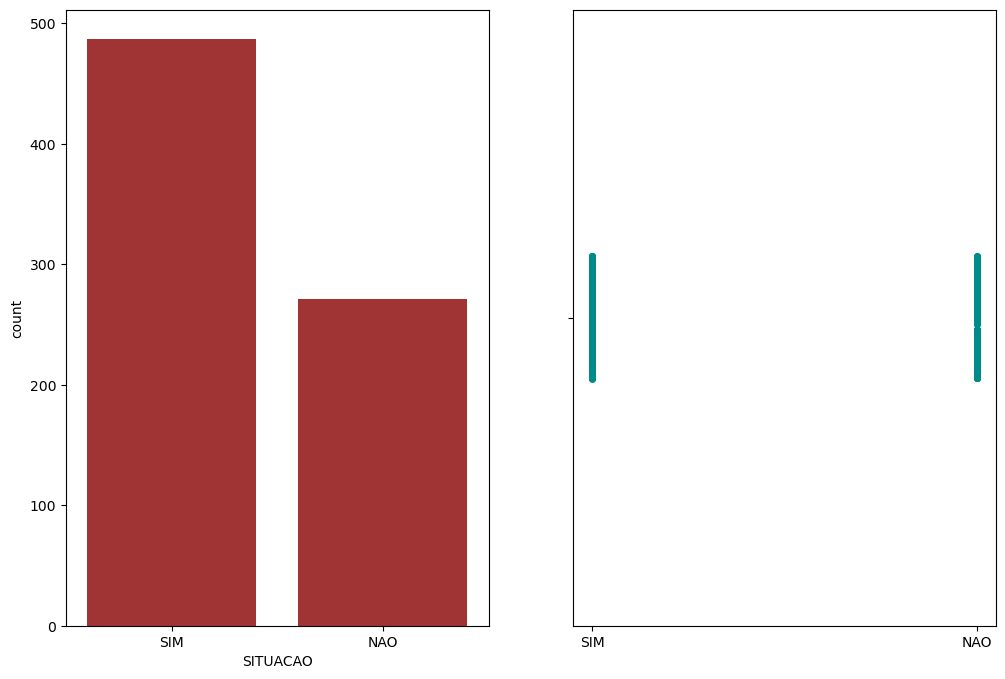

In [97]:
plot_num(df_sinisitro, 'SITUACAO')

In [98]:
df_sinisitro

,ANO,DESCRICAO,GRAU,SITUACAO,SINISTRO
0,2023,"POR FIM, CONTE PARA A GENTE, COM O MÁXIMO DE D...",_10_COLISAO,SIM,1
2,2023,TESTE TESTE TESTE TESTE TESTE TESTE TESTE TEST...,_10_COLISAO,SIM,2
4,2023,"POR FIM, CONTE PARA A GENTE, COM O MÁXIMO DE D...",_10_COLISAO,SIM,3
6,2023,LOREM IPSUM NOSTRA NISL VARIUS IN VITAE PURUS ...,_10_COLISAO,SIM,4
14,2023,"CONTE-NOS COM O MÁXIMO DE DETALHES, COMO TUDO ...",_10_COLISAO,SIM,5
...,...,...,...,...,...
8823,2023,"POR FIM, CONTE PARA A GENTE, COM O MÁXIMO DE D...",_10_COLISAO,SIM,754
8825,2023,"R FIM, CONTE PARA A GENTE, COM O MÁXIMO DE DET...",_10_COLISAO,SIM,755
8826,2023,ESTAVA SAINDO DO CINEMA NA AVENIDA PAULISTA QU...,_10_COLISAO,SIM,756
8827,2023,"POR FAVOR, CONTE PARA A GENTE, COM O MÁXIMO DE...",_10_COLISAO,SIM,757


In [99]:
data = df_sinisitro

In [100]:
import numpy as np
import pandas as pd
import pandas as pd
import requests
import json

In [ ]:
# Suponha que 'df' seja o seu DataFrame
for i, (index, row) in enumerate(data.iterrows()):
    try:
        if i >= 1:
            break  # Sai do loop após 20 registros
        # Seu código para processar cada linha aqui
        descricao_sinistro = row['DESCRICAO']
        numero_sinistro = row['SINISTRO']
        # Montar o payload para a API como um objeto JSON
        payload = {
            "descricaoSinistro": descricao_sinistro,
            "numeroSinistro": numero_sinistro
        }
        # Converter o dicionário em uma string JSON
        payload_json = json.dumps(payload)
        print(f"Chamada para o sinistro {payload_json}")

            # Fazer a chamada à API
        url_api = "http://producer:8000/v1/ressarcimento"
        response = requests.post(url_api, json=payload)
        jsonResponse = response.json()
        uuid = jsonResponse['uuid']

        # Verificar a resposta da API
        if response.status_code == 200:
            print(f"##########INICIO########## {uuid}\n Chamada para o sinistro {numero_sinistro} realizada com sucesso! response: {response.json()}\n##########FIM##########")
        else:
            print(f"##########INICIO########## {uuid}\n Erro na chamada para o sinistro {numero_sinistro}. Status code: {response.status_code} response: {response.json()}\n####################")
    
    except json.JSONDecodeError as err:
        print(f"Erro ao decodificar a string JSON: {err}")
        print(err.response.status_code)
        print(err.response.text)
    except requests.exceptions.HTTPError as err:
        print(f"Erro HTTP: {err}")
        print(err.response.status_code)
        print(err.response.text)
    except requests.exceptions.ConnectionError as err:
        print(f"Erro de conexão: {err}")
        print(err.response.status_code)
        print(err.response.text)
    except requests.exceptions.Timeout as err:
        print(f"Erro de tempo limite: {err}")
        print(err.response.status_code)
        print(err.response.text)
    except requests.exceptions.RequestException as err:
        print(f"Erro desconhecido: {err}")   
        print(err.response.status_code)
        print(err.response.text)

    
